2025-04-28 06:49:28.258254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745815768.277489  496768 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745815768.283111  496768 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745815768.298543  496768 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745815768.298558  496768 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745815768.298560  496768 computation_placer.cc:177] computation placer alr

Using device: cuda
Epoch 1/10 - Train Loss: 1.1350
Validation Loss: 1.0327 | Val Acc: 0.5438
Epoch 2/10 - Train Loss: 0.8729
Validation Loss: 1.0546 | Val Acc: 0.5332
Epoch 3/10 - Train Loss: 0.6757
Validation Loss: 1.1790 | Val Acc: 0.5127
Epoch 4/10 - Train Loss: 0.4877
Validation Loss: 1.4018 | Val Acc: 0.5120
Epoch 5/10 - Train Loss: 0.3480
Validation Loss: 1.6208 | Val Acc: 0.5066
Epoch 6/10 - Train Loss: 0.2623
Validation Loss: 1.8598 | Val Acc: 0.4988
Epoch 7/10 - Train Loss: 0.2176
Validation Loss: 1.9499 | Val Acc: 0.5015
Epoch 8/10 - Train Loss: 0.1864
Validation Loss: 2.0506 | Val Acc: 0.5052
Epoch 9/10 - Train Loss: 0.1642
Validation Loss: 2.1582 | Val Acc: 0.5003
Epoch 10/10 - Train Loss: 0.1468
Validation Loss: 2.1979 | Val Acc: 0.4960

--- Final Test Results ---
Accuracy: 0.4963
Precision: 0.49599663027738217
Recall: 0.4968367773089364

Classification Report:
               precision    recall  f1-score   support

      1 Star       0.64      0.66      0.65      2010
   

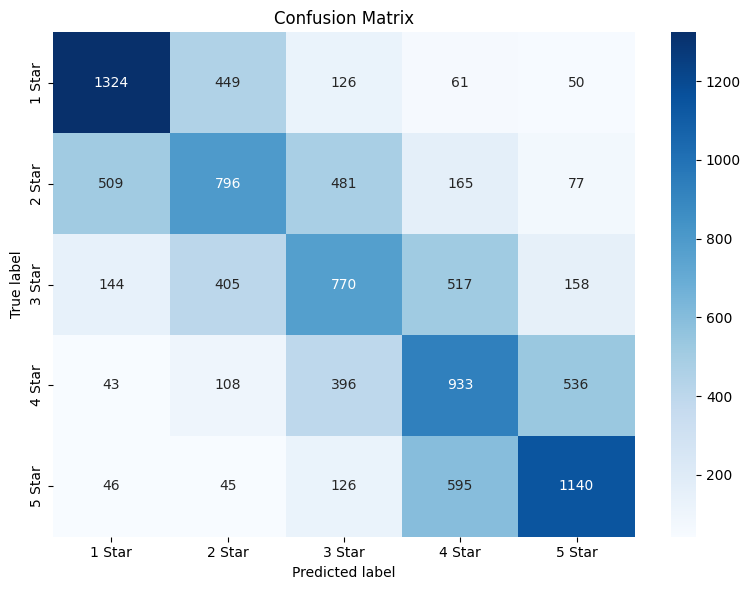

SyntaxError: not a PNG file (<string>)

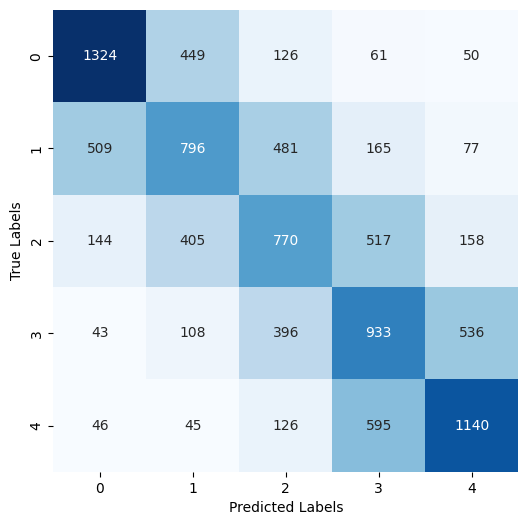

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

# Force CUDA sync for clearer errors
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Device config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Load Yelp dataset
dataset = load_dataset("yelp_review_full")
train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()

# Prepare labels and text
train_df["Sentence"] = train_df["text"].str.lower()
test_df["Sentence"] = test_df["text"].str.lower()
train_df["Class"] = train_df["label"]
test_df["Class"] = test_df["label"]
train_df = train_df[["Sentence", "Class"]]
test_df = test_df[["Sentence", "Class"]]

# Optional: downsample for speed
train_df = train_df.sample(50000, random_state=42)
test_df = test_df.sample(10000, random_state=42)

# Validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["Sentence"].values,
    train_df["Class"].values,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
test_texts = test_df["Sentence"].values
test_labels = test_df["Class"].values

# TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
train_vec = vectorizer.fit_transform(train_texts).toarray()
val_vec = vectorizer.transform(val_texts).toarray()
test_vec = vectorizer.transform(test_texts).toarray()

# Normalize
scaler = MinMaxScaler()
train_vec = scaler.fit_transform(train_vec)
val_vec = scaler.transform(val_vec)
test_vec = scaler.transform(test_vec)

# Convert to tensors
train_x_tensor = torch.tensor(train_vec, dtype=torch.float32)
train_y_tensor = torch.tensor(train_labels, dtype=torch.long)
val_x_tensor = torch.tensor(val_vec, dtype=torch.float32)
val_y_tensor = torch.tensor(val_labels, dtype=torch.long)
test_x_tensor = torch.tensor(test_vec, dtype=torch.float32)
test_y_tensor = torch.tensor(test_labels, dtype=torch.long)

# DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(train_x_tensor, train_y_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_x_tensor, val_y_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(test_x_tensor, test_y_tensor), batch_size=batch_size)

# ANN Model
class SentimentANN(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.4):
        super(SentimentANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 5)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

# Initialize
input_dim = train_x_tensor.shape[1]
model = SentimentANN(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TensorBoard Writer
writer = SummaryWriter("runs/yelp_sentiment_experiment")

# Training
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_true = [], []
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(DEVICE), val_y.to(DEVICE)
            outputs = model(val_x)
            loss = criterion(outputs, val_y)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(val_y.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_true, val_preds)

    print(f"Validation Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Log to TensorBoard
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)

# Final Testing
model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x, test_y = test_x.to(DEVICE), test_y.to(DEVICE)
        outputs = model(test_x)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(test_y.cpu().numpy())

# Metrics
print("\n--- Final Test Results ---")
print("Accuracy:", accuracy_score(test_true, test_preds))
print("Precision:", precision_score(test_true, test_preds, average='macro'))
print("Recall:", recall_score(test_true, test_preds, average='macro'))
print("\nClassification Report:\n", classification_report(test_true, test_preds, target_names=[f"{i+1} Star" for i in range(5)]))

# Confusion Matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f"{i+1} Star" for i in range(5)], yticklabels=[f"{i+1} Star" for i in range(5)])
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# TensorBoard also logs the Confusion Matrix as image
import torchvision
import io

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
buf = io.BytesIO()
plt.savefig(buf, format='jpeg')
buf.seek(0)
image = torchvision.transforms.ToTensor()(plt.imread(buf))
writer.add_image("Confusion Matrix", image, 0)

writer.close()
